In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp
import psycopg2
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sqlalchemy import create_engine 
import os
from dotenv import load_dotenv
load_dotenv("../../.env.postgres")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
conn = psycopg2.connect(
    database = "amazon_uk",
    user = os.environ["POSTGRES_USER"],
    password = os.environ["POSTGRES_PASSWORD"]
)

In [4]:
df = pd.read_sql("SELECT * FROM amazon_uk_2023_professional_med;", conn)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_3288\1050913608.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM amazon_uk_2023_professional_med;", conn)


,index,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,569045,B09H6TR5HS,"VITCOCO Ear Wax Removal Kit Ear Camera, 1920P ...",https://m.media-amazon.com/images/I/61i7DoS5B1...,https://www.amazon.co.uk/dp/B09H6TR5HS,4.2,1576,26.99,False,600,Professional Medical Supplies
1,569046,B01F0XPFHY,Steri Strips Elastic suture wound closure stit...,https://m.media-amazon.com/images/I/41BiQVjEBU...,https://www.amazon.co.uk/dp/B01F0XPFHY,4.5,456,3.38,False,100,Professional Medical Supplies
2,569047,B078P76WN9,Ciringe 20 ml Syringe with 14G Green Mixing Ki...,https://m.media-amazon.com/images/I/616xiiT7KE...,https://www.amazon.co.uk/dp/B078P76WN9,4.4,1608,2.89,False,0,Professional Medical Supplies
3,569048,B09NRNMDBJ,Pegasus Healthcare Blue Disposable Vinyl Medic...,https://m.media-amazon.com/images/I/61ph5MSv-I...,https://www.amazon.co.uk/dp/B09NRNMDBJ,4.3,85,3.35,False,50,Professional Medical Supplies
4,569049,B07GH71HK9,Qualicare First Aid Pupil Gauge Doctors Nurses...,https://m.media-amazon.com/images/I/711imdS2rC...,https://www.amazon.co.uk/dp/B07GH71HK9,4.4,160,3.65,False,300,Professional Medical Supplies


In [5]:
conn.close()

In [6]:
conn_string = os.environ.get("POSTGRES_CONN")
conn = create_engine(conn_string) 

Analyze the statistics

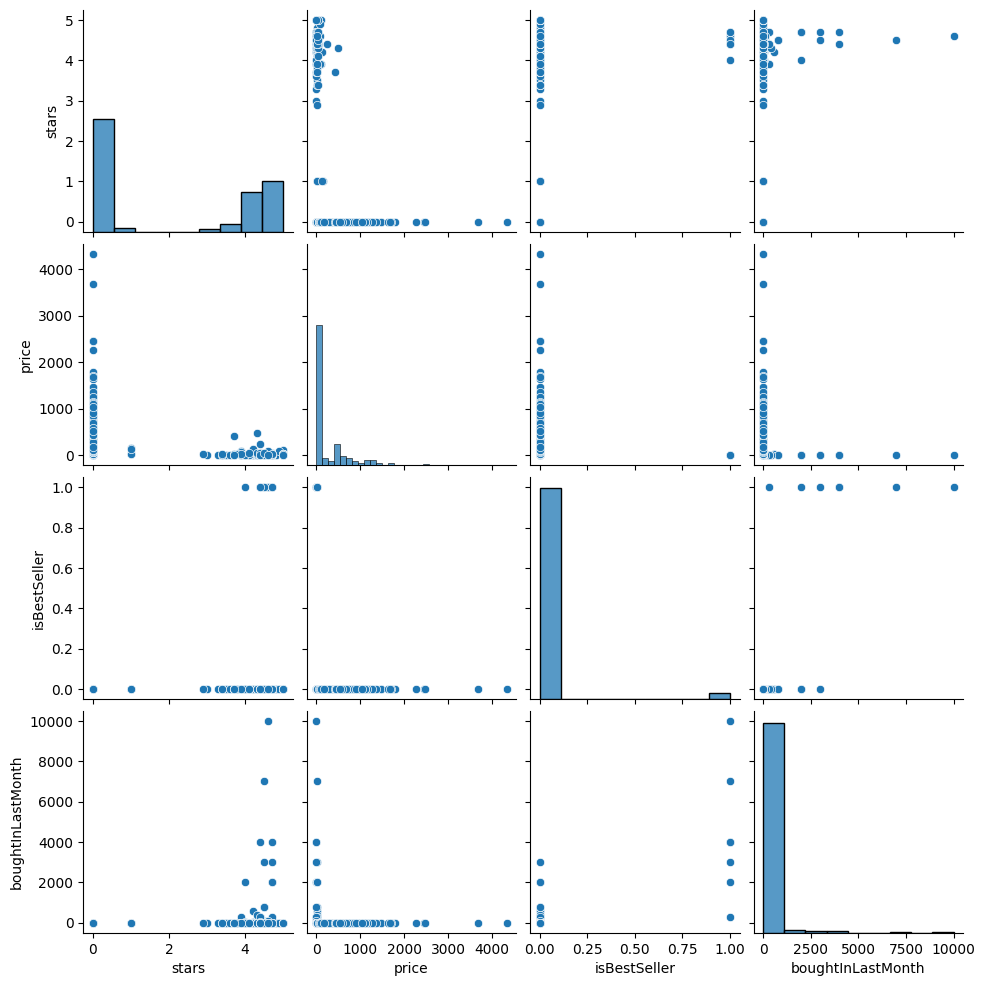

In [7]:
sns.pairplot(df[["stars", "price", "isBestSeller", "boughtInLastMonth"]])

In [8]:
df["hasBought"] = df["boughtInLastMonth"] > 0

In [9]:
df[df["boughtInLastMonth"] > 0].shape[0] / df.shape[0]

0.11328125

<Axes: xlabel='hasBought', ylabel='stars'>

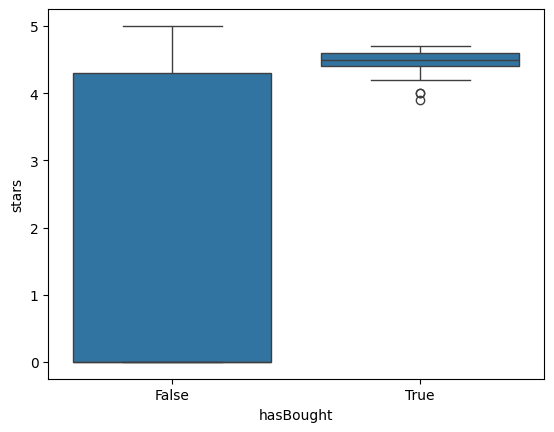

In [10]:
sns.boxplot(data = df, x = "hasBought", y = "stars")

<Axes: xlabel='hasBought', ylabel='price'>

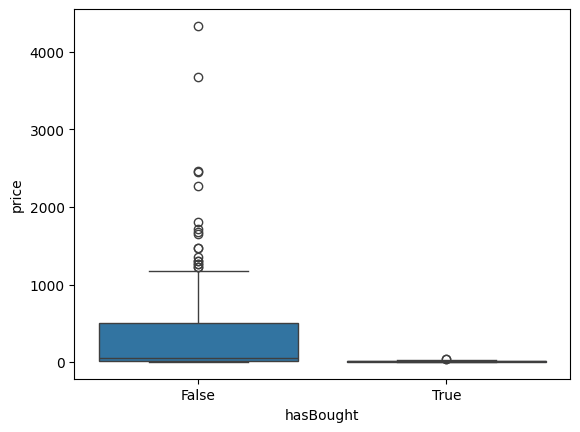

In [11]:
sns.boxplot(data = df, x = "hasBought", y = "price")

In [12]:
df.groupby(["hasBought", "isBestSeller"]).count().iloc[:, 0]

hasBought  isBestSeller
False      False           227
True       False            22
           True              7
Name: index, dtype: int64

In [13]:
# t-test for means of Stars between 2 groups
stars_more_bought = np.array(df[df["hasBought"]]["stars"])
stars_less_bought = np.array(df[~df["hasBought"]]["stars"])
t_test_res = ttest_ind(stars_more_bought, stars_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of stars ratings of has bought vs. no bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of star ratings of has bought vs. no bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of stars ratings of has bought vs. no bought group
t-statistics: 18.317259016002517
p-value: 3.7166637450851533e-48
CI for difference in means of star ratings of has bought vs. no bought group
(2.415824769369981, 2.997907571508038)


In [14]:
# t-test for means of Stars between 2 groups
price_more_bought = np.array(df[df["hasBought"]]["price"])
price_less_bought = np.array(df[~df["hasBought"]]["price"])
t_test_res = ttest_ind(price_more_bought, price_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of price of has bought vs. no bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of price of has bought vs. no bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of price of has bought vs. no bought group
t-statistics: -8.769741076505992
p-value: 4.318367782561301e-16
CI for difference in means of price of has bought vs. no bought group
(-419.6006866550074, -265.6348594485928)


In [15]:
t_test_res = ttest_1samp(np.array(df["price"]), 0)
ci = t_test_res.confidence_interval()
print("CI for means of price of Health & Personal Care product")
print(f"({ci.low}, {ci.high})")

CI for means of price of Health & Personal Care product
(246.79806270285837, 385.68693729714164)


In [16]:
# plot words from products that has someone bought
has_bought_df = df[df["hasBought"]]
has_bought_title_all = " ".join(has_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
has_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', has_bought_title_all)
has_bought_title_all = re.sub(r'\s+', ' ', has_bought_title_all).strip()
# Get all words
has_bought_title_words = has_bought_title_all.split()
# remove stopwords
has_bought_title_words = [w for w in has_bought_title_words if w not in stop_words]
# Set up counter
has_bought_title_words_counter = {}
for w in has_bought_title_words:
    has_bought_title_words_counter[w] = has_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
has_bought_title_words_counter_t = {"word": [], "count": []}
for w in has_bought_title_words_counter:
    has_bought_title_words_counter_t["word"].append(w)
    has_bought_title_words_counter_t["count"].append(has_bought_title_words_counter[w])
has_bought_title_words_df = pd.DataFrame(has_bought_title_words_counter_t)
has_bought_title_words_df = has_bought_title_words_df.sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
has_bought_title_words_df.head()

,word,count
0,ear,14
1,medical,12
2,suture,11
3,kit,11
4,oxygen,9


In [17]:
# plot words from products that no one bought
no_bought_df = df[~df["hasBought"]]
no_bought_title_all = " ".join(no_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
no_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', no_bought_title_all)
no_bought_title_all = re.sub(r'\s+', ' ', no_bought_title_all).strip()
# Get all words
no_bought_title_words = no_bought_title_all.split()
# remove stopwords
no_bought_title_words = [w for w in no_bought_title_words if w not in stop_words]
# Set up counter
no_bought_title_words_counter = {}
for w in no_bought_title_words:
    no_bought_title_words_counter[w] = no_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
no_bought_title_words_counter_t = {"word": [], "count": []}
for w in no_bought_title_words_counter:
    no_bought_title_words_counter_t["word"].append(w)
    no_bought_title_words_counter_t["count"].append(no_bought_title_words_counter[w])
no_bought_title_words_df = pd.DataFrame(no_bought_title_words_counter_t).sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
no_bought_title_words_df.head()

,word,count
0,medical,228
1,model,129
2,supplies,77
3,human,57
4,training,57


In [18]:
# Only on those with bought
only_has_bought = has_bought_title_words_df.merge(no_bought_title_words_df, how = "left", on = "word")
only_has_bought = only_has_bought[only_has_bought["count_y"].isna()]
only_has_bought

,word,count_x,count_y
24,camera,4,NaN
25,removal,4,NaN
26,p,4,NaN
28,lanyard,4,NaN
29,en,4,NaN
...,...,...,...
271,viatom,1,NaN
273,wrist,1,NaN
274,ankle,1,NaN
275,sprains,1,NaN


In [19]:
# Only on those with no bought
only_no_bought = no_bought_title_words_df.merge(has_bought_title_words_df, how = "left", on = "word")
only_no_bought = only_no_bought[only_no_bought["count_y"].isna()]
only_no_bought

,word,count_x,count_y
1,model,129,NaN
5,teaching,52,NaN
6,professional,48,NaN
7,nursing,42,NaN
8,stethoscope,42,NaN
...,...,...,...
1027,fixed,1,NaN
1028,respiratory,1,NaN
1029,modelthoracic,1,NaN
1030,tree,1,NaN


In [20]:
# Save these notable words data to postgres
only_has_bought = only_has_bought[["word", "count_x"]]
only_has_bought = only_has_bought.rename({"count_x": "count"}, axis = 1)
only_has_bought = only_has_bought.reset_index().drop("index", axis = 1)
only_has_bought.to_sql("amazon_uk_2023_promed_product_has_bought_word", conn, if_exists = "replace")

128

In [21]:
# Save these notable words data to postgres
only_no_bought = only_no_bought[["word", "count_x"]]
only_no_bought = only_no_bought.rename({"count_x": "count"}, axis = 1)
only_no_bought = only_no_bought.reset_index().drop("index", axis = 1)
only_no_bought.to_sql("amazon_uk_2023_promed_product_no_bought_word", conn, if_exists = "replace")

883

In [ ]:
for i in range(df.shape[0]):
    if "removal" in df.iloc[i, 2].lower():
        print(df.iloc[i, 2].lower())

In [34]:
for i in range(df.shape[0]):
    if "suturing" in df.iloc[i, 2].lower():
        print(df.iloc[i, 2].lower())

survival medical suture practice kit for students - suture practice kit for suture training, full set of essentials stainless suturing tools, suture pad, gifts for medical students
suturing practice kit for medical students gift nurses veterinarians for complete training kit | reusable silicon skin suture pad
suture practice kit by medical creations - hd videos with a surgeon and advanced ebook training guide - reusable suturing pad with tool kit
